## Import data and packages

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import umap
import seaborn as sns

ATAC = pd.read_csv("data/1.ATAC-Seq data.CSV", sep=";")
# ATAC_Bcells in der Form importieren?
# ATAC_T_Bcells = pd.read_csv("data/ATAC_T_Bcells.csv", sep=";") -> Falsch

c:\Users\Celine\anaconda\envs\envBCells1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Info about the data

In [4]:
ATAC.head()

,ImmGenATAC1219.peakID,chrom,Summit,mm10.60way.phastCons_scores,_-log10_bestPvalue,Included.in.systematic.analysis,TSS,genes.within.100Kb,LTHSC.34-.BM,LTHSC.34+.BM,...,DC.4+.Sp,DC.8+.Sp,DC.pDC.Sp,DC.103+11b+.SI,DC.103+11b-.SI,FRC.SLN,IAP.SLN,BEC.SLN,LEC.SLN,Ep.MEChi.Th
0,ImmGenATAC1219.peak_1,chr1,3020786,0.00,0.56,NaN,NaN,NaN,0.41,0.71,...,0.10,0.10,43525.00,13516.00,0.52,46388.00,0.10,0.57,46447.0,14977.00
1,ImmGenATAC1219.peak_2,chr1,3087226,0.00,0.50,NaN,NaN,NaN,0.41,23377.00,...,45839.00,0.10,14977.00,0.47,0.11,0.92,0.98,42401.00,12451.0,0.94
2,ImmGenATAC1219.peak_3,chr1,3120109,0.07,45879.00,1.0,NaN,NaN,13181.00,0.10,...,0.87,0.54,26330.00,0.95,0.11,63.38,33817.00,12055.00,45748.0,0.11
3,ImmGenATAC1219.peak_4,chr1,3121485,0.15,45691.00,1.0,NaN,NaN,0.41,0.10,...,0.44,30317.00,0.66,0.11,0.92,45790.00,0.98,46753.00,45748.0,0.11
4,ImmGenATAC1219.peak_5,chr1,3372787,0.03,11324.00,NaN,NaN,NaN,0.41,0.10,...,0.44,0.10,0.66,28856.00,0.51,0.92,0.75,12055.00,22282.0,45781.00


In [5]:
ATAC.shape

(512595, 98)

In [6]:
ATAC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512595 entries, 0 to 512594
Data columns (total 98 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   ImmGenATAC1219.peakID            512595 non-null  object 
 1   chrom                            512595 non-null  object 
 2   Summit                           512595 non-null  int64  
 3   mm10.60way.phastCons_scores      512595 non-null  float64
 4   _-log10_bestPvalue               512595 non-null  float64
 5   Included.in.systematic.analysis  334879 non-null  float64
 6   TSS                              14292 non-null   object 
 7   genes.within.100Kb               427710 non-null  object 
 8   LTHSC.34-.BM                     512595 non-null  float64
 9   LTHSC.34+.BM                     512595 non-null  float64
 10  STHSC.150-.BM                    512595 non-null  float64
 11  MPP4.135+.BM                     512595 non-null  float64
 12  pr

In [7]:
ATAC.describe()

,Summit,mm10.60way.phastCons_scores,_-log10_bestPvalue,Included.in.systematic.analysis,LTHSC.34-.BM,LTHSC.34+.BM,STHSC.150-.BM,MPP4.135+.BM,proB.CLP.BM,proB.FrA.BM,...,DC.4+.Sp,DC.8+.Sp,DC.pDC.Sp,DC.103+11b+.SI,DC.103+11b-.SI,FRC.SLN,IAP.SLN,BEC.SLN,LEC.SLN,Ep.MEChi.Th
count,5.125950e+05,512595.000000,512595.00,334879.0,512595.000000,512595.000000,512595.000000,512595.000000,512595.000000,512595.000000,...,512595.000000,512595.000000,512595.000000,512595.000000,512595.000000,512595.000000,512595.000000,512595.000000,512595.000000,512595.000000
mean,7.596866e+07,0.164662,inf,1.0,6095.046919,12936.332385,13396.369554,14257.896763,18034.640712,17227.101166,...,19704.822925,14624.972269,19226.011170,16158.995852,14094.576211,18267.934653,17140.037676,17792.495176,22193.477680,15764.502827
std,4.450542e+07,0.203403,NaN,0.0,9788.773579,14163.202535,16375.735345,16906.870910,18783.480143,18493.944435,...,20004.913558,16857.827083,18360.437997,17876.007879,16726.326963,18369.989966,18401.952190,18063.846271,19084.434031,17767.205876
min,1.430000e+02,0.000000,0.00,1.0,0.410000,0.100000,0.110000,0.110000,0.110000,0.100000,...,0.100000,0.100000,0.110000,0.110000,0.110000,0.110000,0.100000,0.110000,0.110000,0.110000
25%,3.802562e+07,0.030000,27.55,1.0,0.410000,0.710000,0.110000,0.110000,0.470000,0.630000,...,0.770000,0.540000,0.660000,0.530000,0.520000,0.560000,0.720000,0.570000,0.640000,0.530000
50%,7.364690e+07,0.080000,23408.00,1.0,0.410000,73.770000,0.900000,27.810000,16011.000000,12420.000000,...,15462.000000,11475.000000,17319.000000,13516.000000,61.080000,17168.000000,13516.000000,15766.000000,22282.000000,13150.000000
75%,1.091549e+08,0.220000,44197.00,1.0,13181.000000,23377.000000,31048.000000,21217.000000,41365.000000,34335.000000,...,44197.000000,28856.000000,41640.000000,30468.000000,27242.000000,35065.000000,33239.000000,33604.000000,44927.000000,31413.000000
max,1.953715e+08,1.000000,inf,1.0,46017.000000,46296.000000,46296.000000,46508.000000,47453.000000,47453.000000,...,47453.000000,47423.000000,47453.000000,47453.000000,47453.000000,47453.000000,47392.000000,47178.000000,47300.000000,47453.000000


# Data Clean-up

In [8]:
#coloums with numerical datas 
float_cols = ATAC.select_dtypes(include=['float64']).columns
print(float_cols)
ATAC_num = ATAC.select_dtypes(include=['float64'])
ATAC_num.head()

Index(['mm10.60way.phastCons_scores', '_-log10_bestPvalue',
       'Included.in.systematic.analysis', 'LTHSC.34-.BM', 'LTHSC.34+.BM',
       'STHSC.150-.BM', 'MPP4.135+.BM', 'proB.CLP.BM', 'proB.FrA.BM',
       'proB.FrBC.BM', 'preB.FrD.BM', 'B.FrE.BM', 'B1b.PC', 'B.T1.Sp',
       'B.T2.Sp', 'B.T3.Sp', 'B.Sp', 'B.Fem.Sp', 'B.MZ.Sp', 'B.Fo.Sp',
       'B.mem.Sp', 'B.GC.CB.Sp', 'B.GC.CC.Sp', 'B.PB.Sp', 'B.PC.Sp', 'B.PC.BM',
       'preT.DN1.Th', 'preT.DN2a.Th', 'preT.DN2b.Th', 'preT.DN3.Th',
       'T.DN4.Th', 'T.ISP.Th', 'T.DP.Th', 'T.4.Th', 'T.8.Th', 'T.4.Nve.Sp',
       'T.4.Nve.Fem.Sp', 'T.8.Nve.Sp', 'T.4.Sp.aCD3+CD40.18hr',
       'Treg.4.FP3+.Nrplo.Co', 'Treg.4.25hi.Sp', 'T8.TN.P14.Sp',
       'T8.IEL.LCMV.d7.SI', 'T8.TE.LCMV.d7.Sp', 'T8.MP.LCMV.d7.Sp',
       'T8.Tcm.LCMV.d180.Sp', 'T8.Tem.LCMV.d180.Sp', 'NKT.Sp',
       'NKT.Sp.LPS.3hr', 'NKT.Sp.LPS.18hr', 'NKT.Sp.LPS.3d',
       'Tgd.g2+d17.24a+.Th', 'Tgd.g2+d17.LN', 'Tgd.g2+d1.24a+.Th',
       'Tgd.g2+d1.LN', 'Tgd.g1.1+d1.24a+.

,mm10.60way.phastCons_scores,_-log10_bestPvalue,Included.in.systematic.analysis,LTHSC.34-.BM,LTHSC.34+.BM,STHSC.150-.BM,MPP4.135+.BM,proB.CLP.BM,proB.FrA.BM,proB.FrBC.BM,...,DC.4+.Sp,DC.8+.Sp,DC.pDC.Sp,DC.103+11b+.SI,DC.103+11b-.SI,FRC.SLN,IAP.SLN,BEC.SLN,LEC.SLN,Ep.MEChi.Th
0,0.00,0.56,NaN,0.41,0.71,0.90,0.11,34335.00,0.10,0.11,...,0.10,0.10,43525.00,13516.00,0.52,46388.00,0.10,0.57,46447.0,14977.00
1,0.00,0.50,NaN,0.41,23377.00,0.90,0.83,0.47,0.34,0.82,...,45839.00,0.10,14977.00,0.47,0.11,0.92,0.98,42401.00,12451.0,0.94
2,0.07,45879.00,1.0,13181.00,0.10,0.90,0.11,0.47,0.10,0.50,...,0.87,0.54,26330.00,0.95,0.11,63.38,33817.00,12055.00,45748.0,0.11
3,0.15,45691.00,1.0,0.41,0.10,0.11,0.11,0.79,0.40,0.50,...,0.44,30317.00,0.66,0.11,0.92,45790.00,0.98,46753.00,45748.0,0.11
4,0.03,11324.00,NaN,0.41,0.10,0.11,0.11,0.47,0.34,28491.00,...,0.44,0.10,0.66,28856.00,0.51,0.92,0.75,12055.00,22282.0,45781.00


In [9]:
#remove col accoring to Included.in.systematic.analysis 
ATAC_included_values = ATAC_num.drop(columns=['Included.in.systematic.analysis'])
ATAC_included_values = ATAC_included_values.replace([np.inf, -np.inf], np.nan).dropna()
ATAC_included_values.head()

,mm10.60way.phastCons_scores,_-log10_bestPvalue,LTHSC.34-.BM,LTHSC.34+.BM,STHSC.150-.BM,MPP4.135+.BM,proB.CLP.BM,proB.FrA.BM,proB.FrBC.BM,preB.FrD.BM,...,DC.4+.Sp,DC.8+.Sp,DC.pDC.Sp,DC.103+11b+.SI,DC.103+11b-.SI,FRC.SLN,IAP.SLN,BEC.SLN,LEC.SLN,Ep.MEChi.Th
0,0.00,0.56,0.41,0.71,0.90,0.11,34335.00,0.10,0.11,25204.00,...,0.10,0.10,43525.00,13516.00,0.52,46388.00,0.10,0.57,46447.0,14977.00
1,0.00,0.50,0.41,23377.00,0.90,0.83,0.47,0.34,0.82,0.13,...,45839.00,0.10,14977.00,0.47,0.11,0.92,0.98,42401.00,12451.0,0.94
2,0.07,45879.00,13181.00,0.10,0.90,0.11,0.47,0.10,0.50,42736.00,...,0.87,0.54,26330.00,0.95,0.11,63.38,33817.00,12055.00,45748.0,0.11
3,0.15,45691.00,0.41,0.10,0.11,0.11,0.79,0.40,0.50,44958.00,...,0.44,30317.00,0.66,0.11,0.92,45790.00,0.98,46753.00,45748.0,0.11
4,0.03,11324.00,0.41,0.10,0.11,0.11,0.47,0.34,28491.00,42736.00,...,0.44,0.10,0.66,28856.00,0.51,0.92,0.75,12055.00,22282.0,45781.00


In [10]:
# standardizing the values 
scaler = StandardScaler()
ATAC_scaled = scaler.fit_transform(ATAC_included_values)
ATAC_scaled = pd.DataFrame(ATAC_scaled, columns=ATAC_included_values.columns)
ATAC_scaled.head()

,mm10.60way.phastCons_scores,_-log10_bestPvalue,LTHSC.34-.BM,LTHSC.34+.BM,STHSC.150-.BM,MPP4.135+.BM,proB.CLP.BM,proB.FrA.BM,proB.FrBC.BM,preB.FrD.BM,...,DC.4+.Sp,DC.8+.Sp,DC.pDC.Sp,DC.103+11b+.SI,DC.103+11b-.SI,FRC.SLN,IAP.SLN,BEC.SLN,LEC.SLN,Ep.MEChi.Th
0,-0.809539,-1.322500,-0.622619,-0.913335,-0.818014,-0.843321,0.867794,-0.931503,-0.956155,0.241998,...,-0.985004,-0.867550,1.323434,-0.147860,-0.842635,1.530753,-0.931429,-0.984957,1.270846,-0.044332
1,-0.809539,-1.322503,-0.622619,0.737160,-0.818014,-0.843278,-0.960118,-0.931490,-0.956118,-1.104052,...,1.306379,-0.867550,-0.231432,-0.903931,-0.842659,-0.994405,-0.931381,1.362299,-0.510506,-0.887236
2,-0.465393,1.249028,0.723878,-0.913378,-0.818014,-0.843321,-0.960118,-0.931503,-0.956135,1.178320,...,-0.984966,-0.867524,0.386909,-0.903904,-0.842659,-0.991005,0.906252,-0.317633,1.234219,-0.887283
3,-0.072084,1.238491,-0.622619,-0.913378,-0.818063,-0.843321,-0.960101,-0.931487,-0.956135,1.296989,...,-0.984987,0.930837,-1.047119,-0.903951,-0.842611,1.498200,-0.931381,1.603222,1.234219,-0.887283
4,-0.662048,-0.687811,-0.622619,-0.913378,-0.818063,-0.843321,-0.960118,-0.931490,0.543993,1.178320,...,-0.984987,-0.867550,-1.047119,0.710273,-0.842635,-0.994405,-0.931393,-0.317633,0.004627,1.689424


In [11]:
# check if standardization worked
print("mean (should be ~0):", np.mean(ATAC_scaled, axis=0))
print("sd (should be ~1):", np.std(ATAC_scaled, axis=0))

mean (should be ~0): mm10.60way.phastCons_scores   -1.188789e-16
_-log10_bestPvalue            -1.480996e-16
LTHSC.34-.BM                  -3.077323e-16
LTHSC.34+.BM                   6.387524e-17
STHSC.150-.BM                  7.474290e-17
                                   ...     
FRC.SLN                        3.832514e-16
IAP.SLN                       -1.583574e-16
BEC.SLN                        3.459909e-17
LEC.SLN                       -1.517037e-16
Ep.MEChi.Th                    2.708044e-16
Length: 92, dtype: float64
sd (should be ~1): mm10.60way.phastCons_scores    1.0
_-log10_bestPvalue             1.0
LTHSC.34-.BM                   1.0
LTHSC.34+.BM                   1.0
STHSC.150-.BM                  1.0
                              ... 
FRC.SLN                        1.0
IAP.SLN                        1.0
BEC.SLN                        1.0
LEC.SLN                        1.0
Ep.MEChi.Th                    1.0
Length: 92, dtype: float64


## Clustering


In [12]:
#Number of clusters ?
K = range(1, 11)
a = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(ATAC_scaled)
    a.append(kmeans.inertia_)

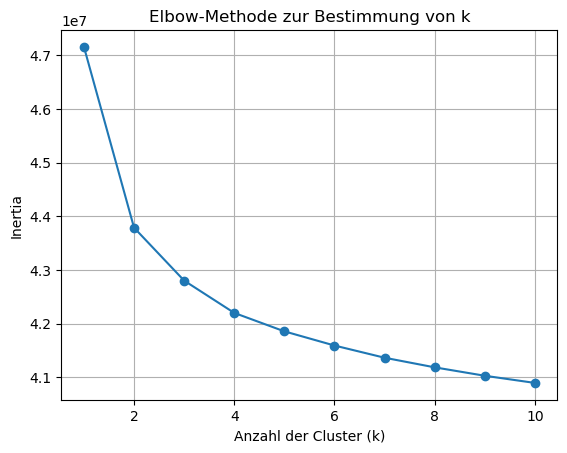

In [13]:
#Elbow-Plot zur Wahl der optimalen Clusterzahl 
plt.plot(K, a, marker='o')
plt.xlabel('Anzahl der Cluster (k)')
plt.ylabel('Inertia')
plt.title('Elbow-Methode zur Bestimmung von k')
plt.grid(True)
plt.show()

In [14]:
#Kein klarer Knick zu sehen, aber zwischen k=3 und k=5 flacht die Kurve ab
#Reduzierung auf 10 Dimensionen durch PCA 
pca = PCA(n_components=10)
ATAC_pca10 = pca.fit_transform(ATAC_scaled)

#Zur genauen bestimmung wird noch der Silhouette Score verwendet mit 10 Dimensionen
silhouette_scores = []

for k in range(2, 11):  # Silhouette macht bei k=1 keinen Sinn
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(ATAC_pca10)
    score = silhouette_score(ATAC_pca10, kmeans.labels_)
    silhouette_scores.append(score)

#Plot
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Anzahl der Cluster (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette-Analyse zur Wahl von k')
plt.grid(True)
plt.show()

#da es es auch mit PCA sehr lange dauert (20 min und immernoch nicht fertig) mach ich erstmal mit elbow method weiter
#lasse das hier als markdown falls wir es doch noch machen wollen

In [15]:
#Clustering mit k=(3,4,5) ausprobieren
kmeans_3 = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_3.fit(ATAC_scaled)

kmeans_4 = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans_4.fit(ATAC_scaled)

kmeans_5 = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans_5.fit(ATAC_scaled)

labels_3 = kmeans_3.labels_
labels_4 = kmeans_4.labels_
labels_5 = kmeans_5.labels_

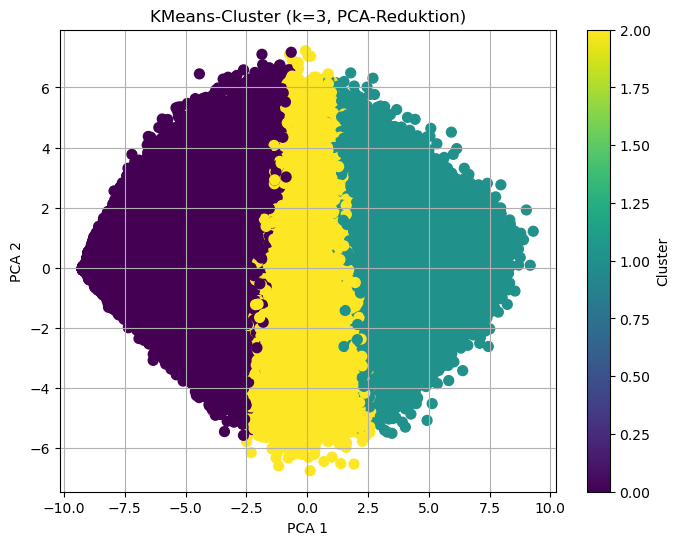

In [16]:
#Zur Visualisierung PCA und Cluster-Plot 
pca = PCA(n_components=2)
ATAC_pca = pca.fit_transform(ATAC_scaled)

#für k=3
plt.figure(figsize=(8,6))
plt.scatter(ATAC_pca[:, 0], ATAC_pca[:, 1], c=labels_3, cmap='viridis', s=50)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('KMeans-Cluster (k=3, PCA-Reduktion)')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

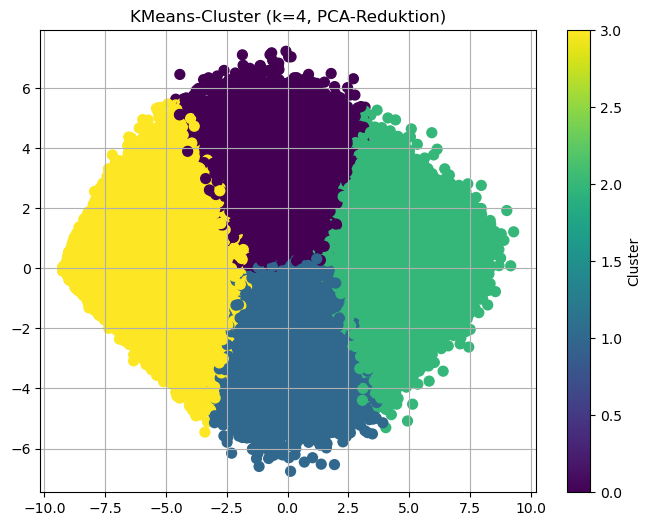

In [17]:
#für k=4
plt.figure(figsize=(8,6))
plt.scatter(ATAC_pca[:, 0], ATAC_pca[:, 1], c=labels_4, cmap='viridis', s=50)
plt.title('KMeans-Cluster (k=4, PCA-Reduktion)')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

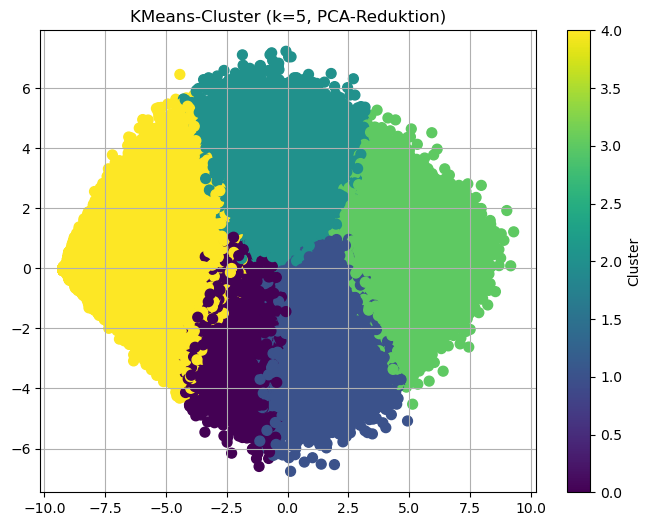

In [18]:
#für k=5
plt.figure(figsize=(8,6))
plt.scatter(ATAC_pca[:, 0], ATAC_pca[:, 1], c=labels_5, cmap='viridis', s=50)
plt.title('KMeans-Cluster (k=5, PCA-Reduktion)')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

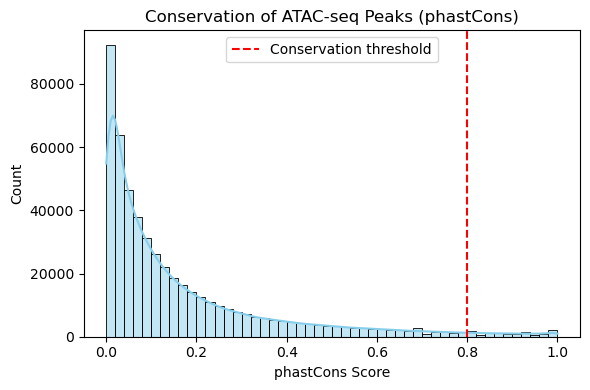

In [19]:
# PhastCons Conservation Score Distribution of ATAC-seq Peaks
phast_scores = ATAC["mm10.60way.phastCons_scores"].dropna()

plt.figure(figsize=(6, 4))
sns.histplot(phast_scores, bins=50, kde=True, color='skyblue')
plt.axvline(0.8, color='red', linestyle='--', label='Conservation threshold')
plt.xlabel('phastCons Score')
plt.title('Conservation of ATAC-seq Peaks (phastCons)')
plt.legend()
plt.tight_layout()
plt.show()


c:\Users\Celine\anaconda\envs\envBCells1\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


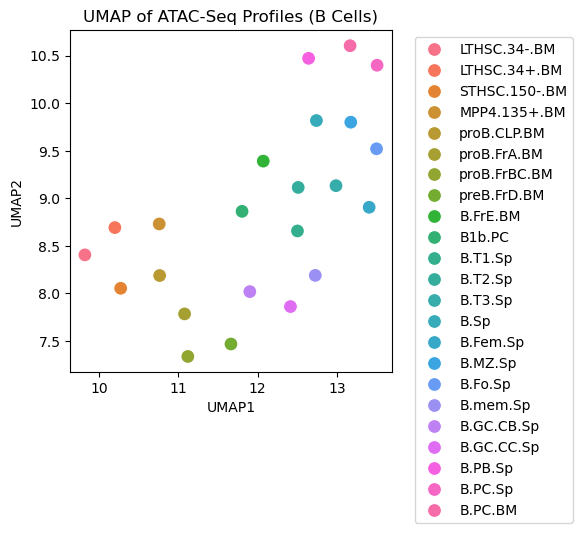

In [20]:
# Select the cell columns (columns 9 to 31; Python is zero-indexed, so columns 8 to 30)
cell_columns = ATAC.columns[8:31]

# Peak matrix: rows = peaks, columns = cells
signal = ATAC[cell_columns]

# Convert to numpy array
signal_values = signal.values

# Clean NaN and infinite values
signal_clean = np.nan_to_num(signal_values, nan=0.0, posinf=1e10, neginf=-1e10)

# Standardize the data
signal_scaled = StandardScaler().fit_transform(signal_clean)

# UMAP (transpose so cells are rows)
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(signal_scaled.T)

# Create a DataFrame with UMAP results and cell names
umap_df = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])
umap_df["Sample"] = cell_columns

# Plot
plt.figure(figsize=(6, 5))
sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", hue="Sample", s=100)
plt.title("UMAP of ATAC-Seq Profiles (B Cells)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ATAC transposed dataset - B-cell specific

In [21]:
# of scaled values
ATAC_scaled_Peaks_Bcells = ATAC_scaled.iloc[:, 2:31]
ATAC_T_scaled_Bcells = ATAC_scaled_Peaks_Bcells.T
ATAC_T_scaled_Bcells.head()

,0,1,2,3,4,5,6,7,8,9,...,512580,512581,512582,512583,512584,512585,512586,512587,512588,512589
LTHSC.34-.BM,-0.622619,-0.622619,0.723878,-0.622619,-0.622619,0.723878,-0.622619,0.723878,0.767295,-0.621946,...,0.767295,-0.622619,-0.622619,-0.622619,0.723878,0.767295,-0.622619,-0.622619,-0.622619,-0.622619
LTHSC.34+.BM,-0.913335,0.737160,-0.913378,-0.913378,-0.913378,0.737160,-0.913378,-0.913335,-0.913378,-0.913378,...,-0.912441,0.558881,2.355367,0.156853,1.138976,1.138976,0.156853,-0.913335,0.737160,-0.913335
STHSC.150-.BM,-0.818014,-0.818014,-0.818014,-0.818063,-0.818063,1.077905,-0.818063,-0.818014,-0.818014,-0.818063,...,0.451491,0.722929,0.345481,1.077905,-0.818014,0.345481,0.345481,-0.818063,-0.818063,-0.818014
MPP4.135+.BM,-0.843321,-0.843278,-0.843321,-0.843321,-0.843321,0.409772,-0.843321,-0.843321,-0.843321,-0.843321,...,-0.025909,0.411606,1.642998,0.218844,1.642998,0.411606,1.862672,-0.843278,-0.843278,0.218844
proB.CLP.BM,0.867794,-0.960118,-0.960118,-0.960101,-0.960118,1.488393,-0.960137,0.148332,-0.960120,-0.960118,...,1.482909,0.172555,0.772231,0.524194,1.473752,1.397622,-0.057541,-0.960095,-0.960095,0.694450


In [22]:
# included in systematic analysis - makes more sense because we only look at B-cells anyway
ATAC_included_values_Bcells = ATAC_included_values.iloc[:, 2:25]
ATAC_T_included_values_Bcells = ATAC_included_values_Bcells.T
ATAC_T_included_values_Bcells.head()

,0,1,2,3,4,5,6,7,8,9,...,512585,512586,512587,512588,512589,512590,512591,512592,512593,512594
LTHSC.34-.BM,0.41,0.41,13181.00,0.41,0.41,13181.0,0.41,13181.00,13606.00,7.00,...,13606.00,0.41,0.41,0.41,13181.0,13606.0,0.41,0.41,0.41,0.41
LTHSC.34+.BM,0.71,23377.00,0.10,0.10,0.10,23377.0,0.10,0.71,0.10,0.10,...,13.37,20852.00,46296.00,15158.00,29068.0,29068.0,15158.00,0.71,23377.00,0.71
STHSC.150-.BM,0.90,0.90,0.90,0.11,0.11,31048.0,0.11,0.90,0.90,0.11,...,20790.00,25235.00,19054.00,31048.00,0.9,19054.0,19054.00,0.11,0.11,0.90
MPP4.135+.BM,0.11,0.83,0.11,0.11,0.11,21186.0,0.11,0.11,0.11,0.11,...,13820.00,21217.00,42036.00,17958.00,42036.0,21217.0,45750.00,0.83,0.83,17958.00
proB.CLP.BM,34335.00,0.47,0.47,0.79,0.47,45992.0,0.11,20821.00,0.42,0.47,...,45889.00,21276.00,32540.00,27881.00,45717.0,44287.0,16954.00,0.90,0.90,31079.00


# Plots

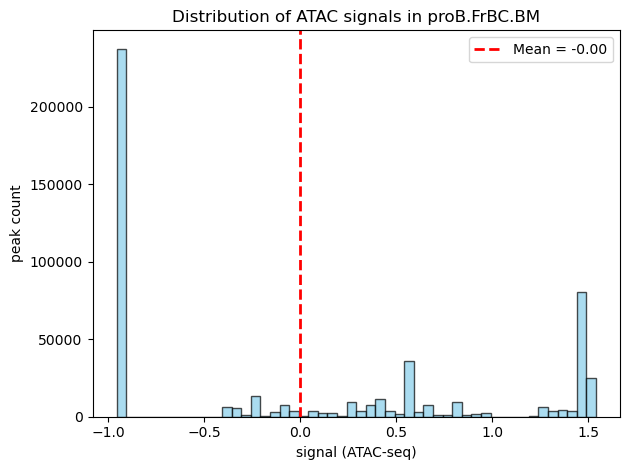

In [23]:
# select column – z. B. for examole cell type "proB.FrBC.BM"
values = ATAC_scaled["proB.FrBC.BM"].dropna()

# calculate mean
mean_val = values.mean()

# Histogram with mean line
plt.hist(values, bins=50, color="skyblue", edgecolor="black", alpha=0.7)
plt.axvline(mean_val, color="red", linestyle="dashed", linewidth=2, label=f"Mean = {mean_val:.2f}")
plt.xlabel("signal (ATAC-seq)")
plt.ylabel("peak count")
plt.title("Distribution of ATAC signals in proB.FrBC.BM")
plt.legend()
plt.tight_layout()
plt.show()

### Mean signal per peak across cell types
For each row (peak), we calculated the mean across all columns containing cell type-specific signal values.

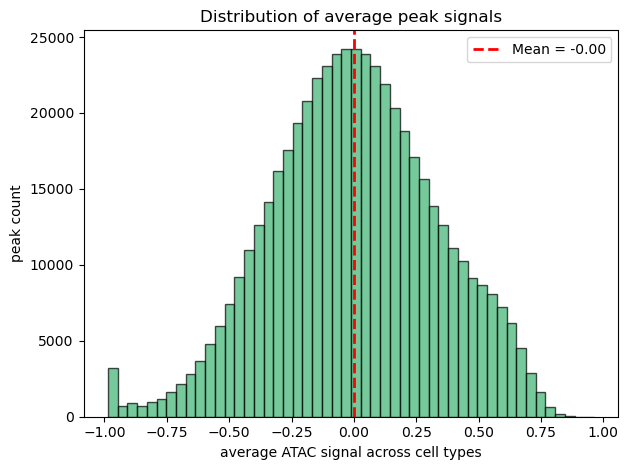

In [25]:
signal_columns = ATAC_scaled.columns[2:92] 

# Mean across these columns (per row)
ATAC_scaled["peak_mean_signal"] = ATAC_scaled[signal_columns].mean(axis=1)

# Histogram of the mean of all peaks
plt.hist(ATAC_scaled["peak_mean_signal"].dropna(), bins=50, color="mediumseagreen", edgecolor="black", alpha=0.7)
plt.axvline(ATAC_scaled["peak_mean_signal"].mean(), color="red", linestyle="dashed", linewidth=2, label=f"Mean = {ATAC_scaled['peak_mean_signal'].mean():.2f}")
plt.xlabel("average ATAC signal across cell types")
plt.ylabel("peak count")
plt.title("Distribution of average peak signals")
plt.legend()
plt.tight_layout()
plt.show()

### Distribution of average peak signals in B cells - Histogram

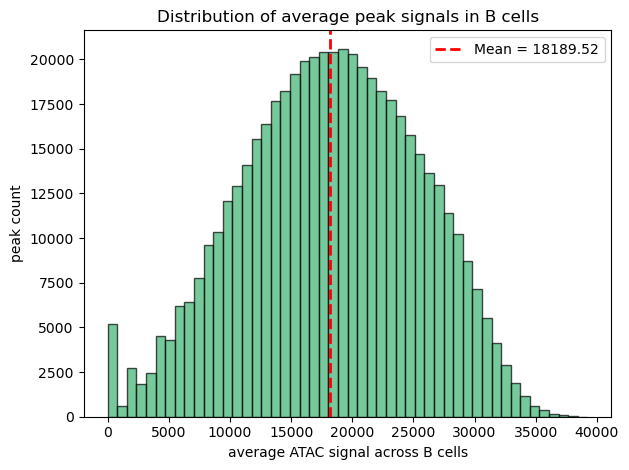

In [26]:
# matrix with ATAC-Seq peaks of B-cells
signal_columns = ATAC_included_values.columns[2:25] 

# mean across columns of B-cells (per row)
ATAC_included_values["peak_mean_signal"] = ATAC_included_values[signal_columns].mean(axis=1)

# Histogramm des Mittelwerts aller Peaks
plt.hist(ATAC_included_values["peak_mean_signal"].dropna(), bins=50, color="mediumseagreen", edgecolor="black", alpha=0.7)
plt.axvline(ATAC_included_values["peak_mean_signal"].mean(), color="red", linestyle="dashed", linewidth=2, label=f"Mean = {ATAC_included_values['peak_mean_signal'].mean():.2f}")
plt.xlabel("average ATAC signal across B cells")
plt.ylabel("peak count")
plt.title("Distribution of average peak signals in B cells")
plt.legend()
plt.tight_layout()
plt.show()

### Distribution of ATAC-Seq mean values per B-cell specific cell types - Histogram

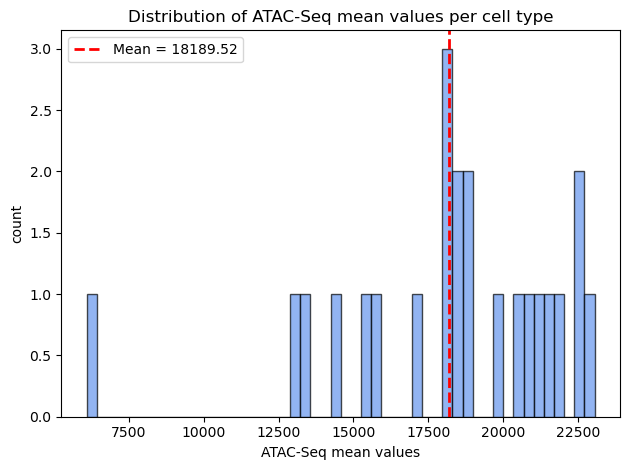

In [27]:

# copy of the B-cell specific transformed matrix
ATAC_T_included_values_Bcells_copy = ATAC_T_included_values_Bcells.copy()

# mean per row across all columns
ATAC_T_included_values_Bcells_copy["row_mean"] = ATAC_T_included_values_Bcells_copy.mean(axis=1)

# Histogramm plotten
plt.hist(ATAC_T_included_values_Bcells_copy["row_mean"].dropna(), bins=50, color="cornflowerblue", edgecolor="black", alpha=0.7)
plt.axvline(ATAC_T_included_values_Bcells_copy["row_mean"].mean(), color="red", linestyle="dashed", linewidth=2, label=f"Mean = {ATAC_T_included_values_Bcells_copy['row_mean'].mean():.2f}")
plt.xlabel("ATAC-Seq mean values")
plt.ylabel("count")
plt.title("Distribution of ATAC-Seq mean values per cell type")
plt.legend()
plt.tight_layout()
plt.show()

### Distribution of ATAC-Seq median values per B-cell specific cell types - Histogram

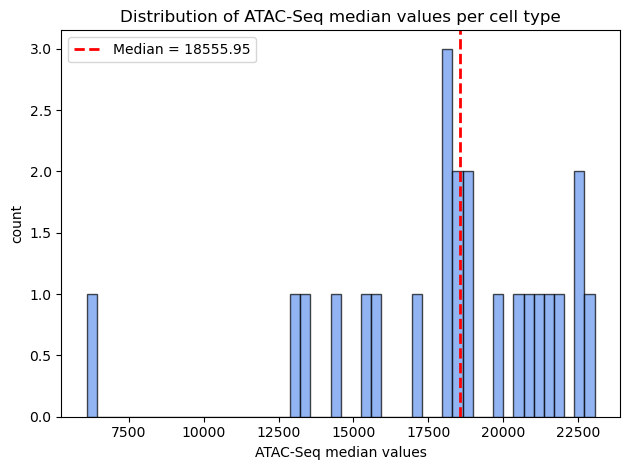

In [28]:

# copy of the B-cell specific transformed matrix
ATAC_T_included_values_Bcells_copy = ATAC_T_included_values_Bcells.copy()

# median per row across all columns
ATAC_T_included_values_Bcells_copy["row_mean"] = ATAC_T_included_values_Bcells_copy.mean(axis=1)

# Histogramm plotten
plt.hist(ATAC_T_included_values_Bcells_copy["row_mean"].dropna(), bins=50, color="cornflowerblue", edgecolor="black", alpha=0.7)
plt.axvline(ATAC_T_included_values_Bcells_copy["row_mean"].median(), color="red", linestyle="dashed", linewidth=2, label=f"Median = {ATAC_T_included_values_Bcells_copy['row_mean'].median():.2f}")
plt.xlabel("ATAC-Seq median values")
plt.ylabel("count")
plt.title("Distribution of ATAC-Seq median values per cell type")
plt.legend()
plt.tight_layout()
plt.show()

### Significance vs. conservation - Scatter plot

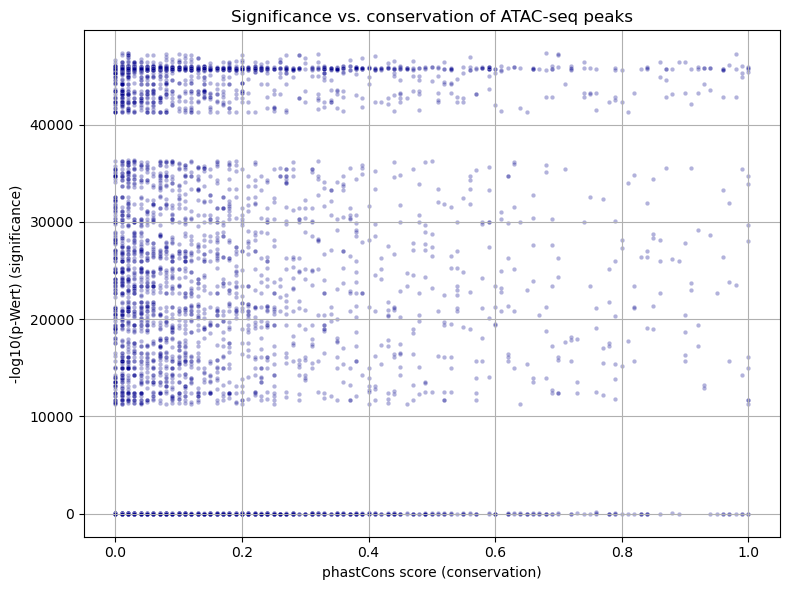

In [29]:
# selection of the two columns

ATAC_filtered = ATAC[["_-log10_bestPvalue", "mm10.60way.phastCons_scores"]].dropna()

# scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=ATAC_filtered.sample(n=5000, random_state=42),  # optional: nur 5000 Punkte für bessere Performance
    x="mm10.60way.phastCons_scores",
    y="_-log10_bestPvalue",
    alpha=0.3,
    s=10,
    color="darkblue"
)
plt.xlabel("phastCons score (conservation)")
plt.ylabel("-log10(p-Wert) (significance)")
plt.title("Significance vs. conservation of ATAC-seq peaks")
plt.grid(True)
plt.tight_layout()
plt.show()


### 1. Differences and similarities of the chromatin landscape between immune cells

#### i. How variable is the chromatin signal within cells?

##### a) Is the signal dependent on sequencing depth, number of input cells, QC metric?

For that we first calculated the mean signal for all peaks per cell type.
Afterwards we linked the QC data with the signal. A scatterplot shows the Signal vs.different aspects. Then we calculated the correlation and visualized it. 

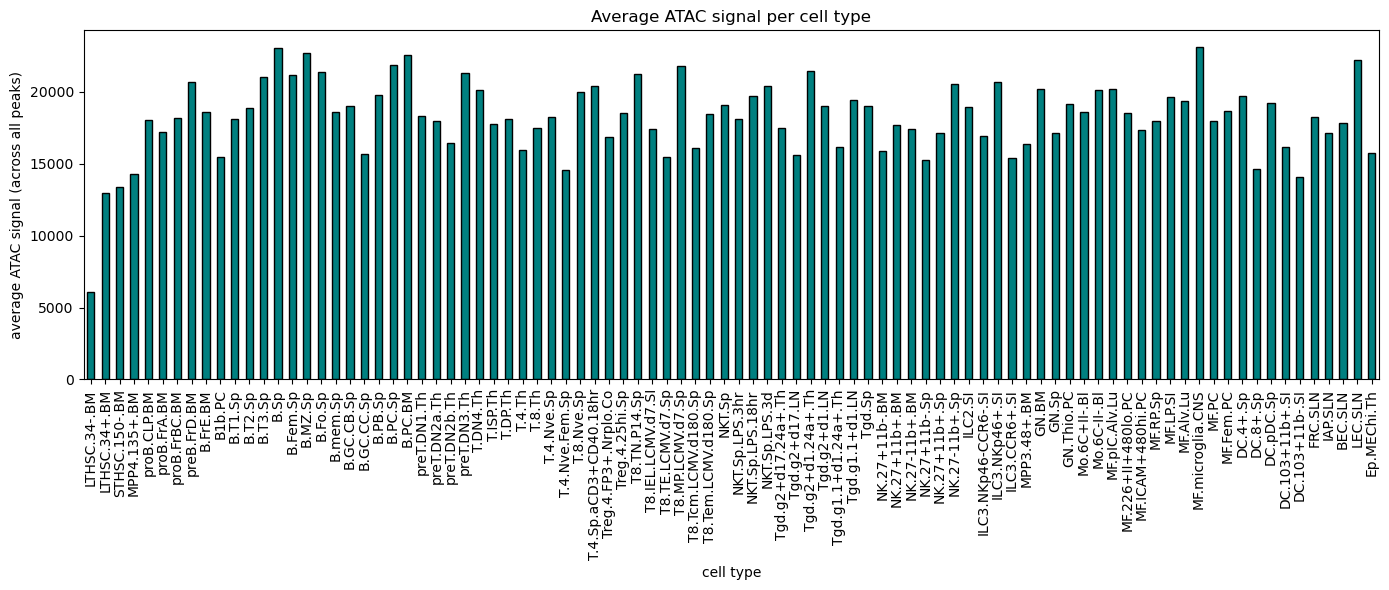

In [31]:
# matrix with all cell types and corresponding ATAC-seq peaks
celltype_columns = ATAC_scaled.columns[2:92] 

# mean per cell type (across all peaks)
celltype_means = ATAC[celltype_columns].mean()

# plot
plt.figure(figsize=(14, 6))
celltype_means.plot(kind="bar", color="teal", edgecolor="black")
plt.ylabel("average ATAC signal (across all peaks)")
plt.xlabel("cell type")
plt.title("Average ATAC signal per cell type")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



In [53]:
# load the converted QC matric 
QC_conv_num = pd.read_csv("data/QC_converted_numerical.CSV")

#group QC/ 
QC_mean = QC_conv_num.groupby("CellType").mean()

#link mean values with the QC data
ATAC_combined = pd.concat([celltype_means, QC_mean], axis=1)
ATAC_combined = ATAC_combined.rename(columns={0: "ATAC_mean"})

ATAC_combined.head()


,ATAC_mean,InputCellNumber,PF.reads,%chrM.mapped,Paired.read.after.removing.PCR.duplication,%fragment.1Kb_TSS,Replicate.cor
LTHSC.34-.BM,6095.046919,677.0,22287984.0,4.580,2470102.0,10.600,NaN
LTHSC.34+.BM,12936.332385,2483.0,28588536.0,3.170,7675501.0,7.700,NaN
STHSC.150-.BM,13396.369554,3660.0,22170346.0,3.250,6060045.0,11.130,NaN
MPP4.135+.BM,14257.896763,10000.0,24003590.0,13.830,6128252.0,18.960,NaN
proB.CLP.BM,18034.640712,10000.0,21903414.0,9.035,6347376.5,15.605,0.868


In [52]:
print(ATAC_combined.columns)

Index([                                           0,
                                  'InputCellNumber',
                                         'PF.reads',
                                     '%chrM.mapped',
       'Paired.read.after.removing.PCR.duplication',
                                '%fragment.1Kb_TSS',
                                    'Replicate.cor'],
      dtype='object')


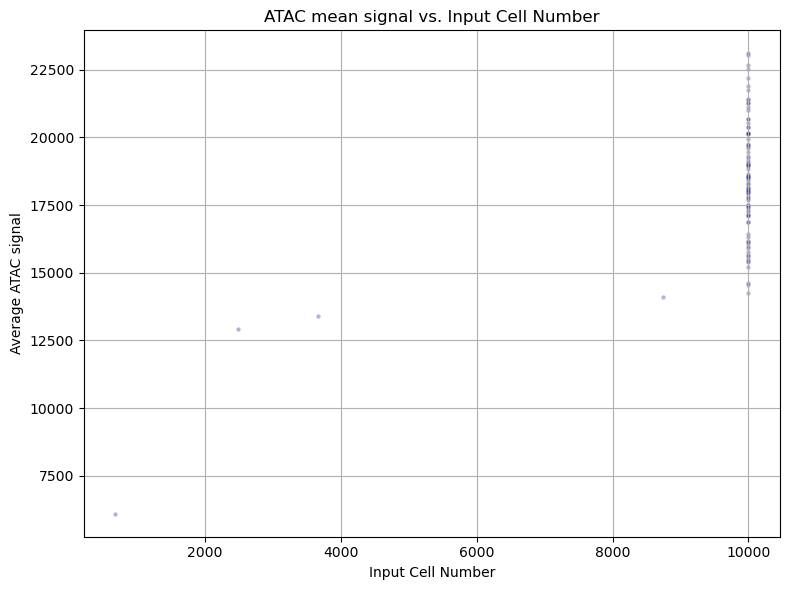

In [ ]:
#scatterplot of ATAC-Signal vs. Input Cell number
plt.figure(figsize=(8, 6))
sns.scatterplot(data=ATAC_combined, x="InputCellNumber", y="ATAC_mean", alpha=0.3, s=10, color="darkblue")

plt.xlabel("Input Cell Number")
plt.ylabel("Average ATAC signal")
plt.title("ATAC mean signal vs. Input Cell Number")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# does input cell number really just contain 10.000?
ATAC_combined["InputCellNumber"].value_counts()

InputCellNumber
10000.0    86
677.0       1
2483.0      1
3660.0      1
8750.0      1
Name: count, dtype: int64

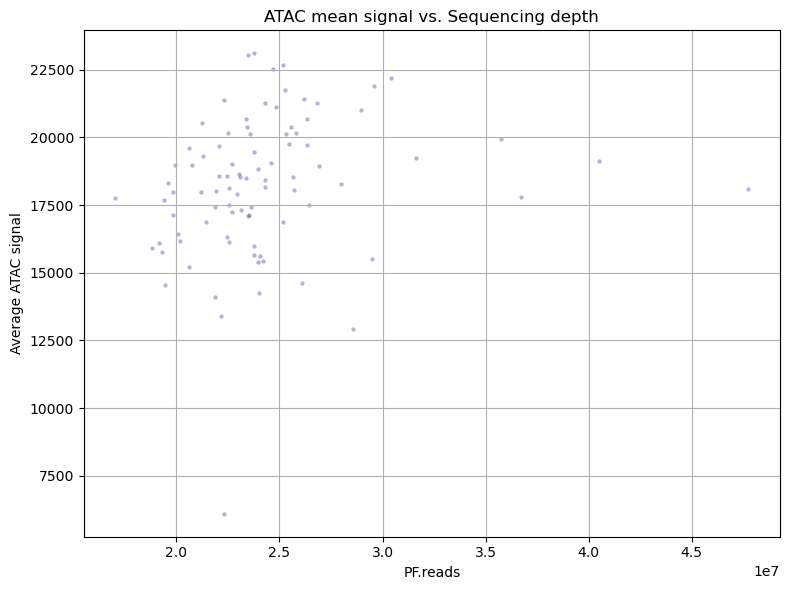

In [ ]:
#scatterplot of ATAC-Signal vs. Sequencing depth
plt.figure(figsize=(8, 6))
sns.scatterplot(data=ATAC_combined, x="PF.reads", y="ATAC_mean", alpha=0.3, s=10, color="darkblue")

plt.xlabel("PF.reads")
plt.ylabel("Average ATAC signal")
plt.title("ATAC mean signal vs. Sequencing depth")
plt.grid(True)
plt.tight_layout()
plt.show()

#says how many reads there are -> more mean better information 
# do you only look at strongly open parts (low sequencing depth) or also at weakly open parts (high depth)

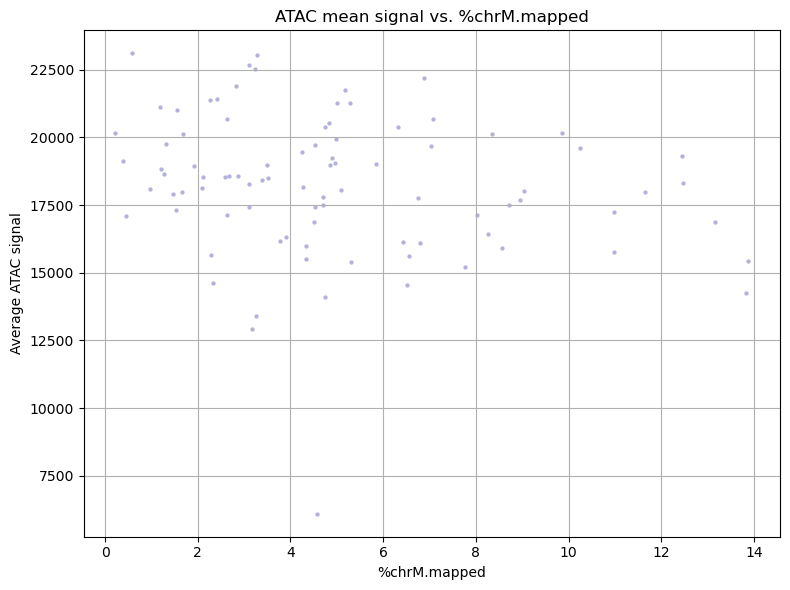

In [ ]:
#scatterplot of ATAC-Signal vs. %chrM.mapped
plt.figure(figsize=(8, 6))
sns.scatterplot(data=ATAC_combined, x="%chrM.mapped", y="ATAC_mean", alpha=0.3, s=10, color="darkblue")

plt.xlabel("%chrM.mapped")
plt.ylabel("Average ATAC signal")
plt.title("ATAC mean signal vs. %chrM.mapped")
plt.grid(True)
plt.tight_layout()
plt.show()

#how many reads are from mitochondria (not useful)

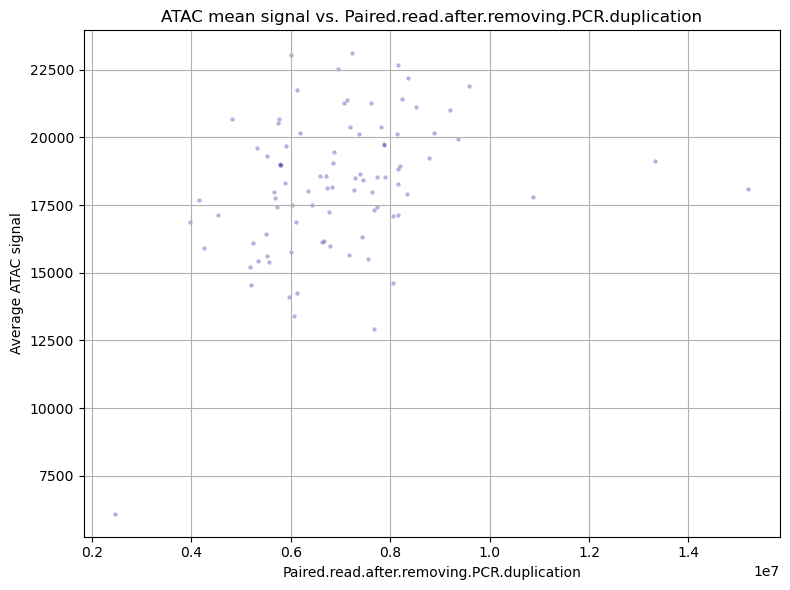

In [ ]:
#scatterplot of ATAC-Signal vs. Paired.read.after.removing.PCR.duplication
plt.figure(figsize=(8, 6))
sns.scatterplot(data=ATAC_combined, x="Paired.read.after.removing.PCR.duplication", y="ATAC_mean", alpha=0.3, s=10, color="darkblue")

plt.xlabel("Paired.read.after.removing.PCR.duplication")
plt.ylabel("Average ATAC signal")
plt.title("ATAC mean signal vs. Paired.read.after.removing.PCR.duplication")
plt.grid(True)
plt.tight_layout()
plt.show()

#how many unique reads after removing duplications 

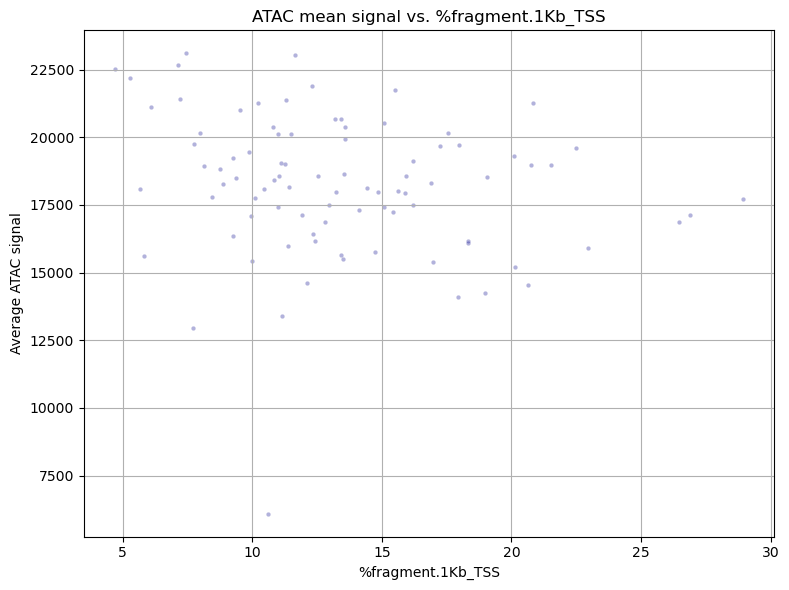

In [ ]:
#scatterplot of ATAC-Signal vs. %fragment.1Kb_TSS
plt.figure(figsize=(8, 6))
sns.scatterplot(data=ATAC_combined, x="%fragment.1Kb_TSS", y="ATAC_mean", alpha=0.3, s=10, color="darkblue")

plt.xlabel("%fragment.1Kb_TSS")
plt.ylabel("Average ATAC signal")
plt.title("ATAC mean signal vs. %fragment.1Kb_TSS")
plt.grid(True)
plt.tight_layout()
plt.show()

#how many reads are close to start of gene

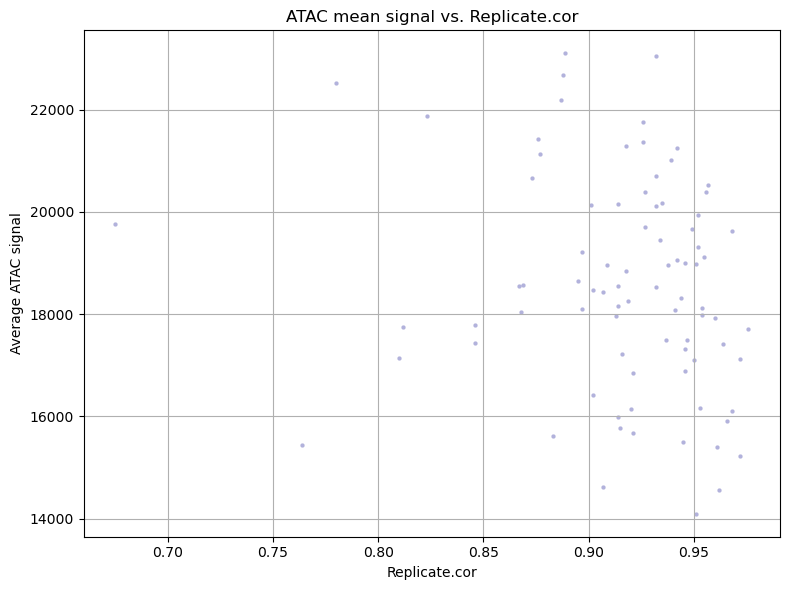

In [ ]:
#scatterplot of ATAC-Signal vs. Replicate.cor
plt.figure(figsize=(8, 6))
sns.scatterplot(data=ATAC_combined, x="Replicate.cor", y="ATAC_mean", alpha=0.3, s=10, color="darkblue")

plt.xlabel("Replicate.cor")
plt.ylabel("Average ATAC signal")
plt.title("ATAC mean signal vs. Replicate.cor")
plt.grid(True)
plt.tight_layout()
plt.show()

#how similar was the experiment when doing it multiple times 

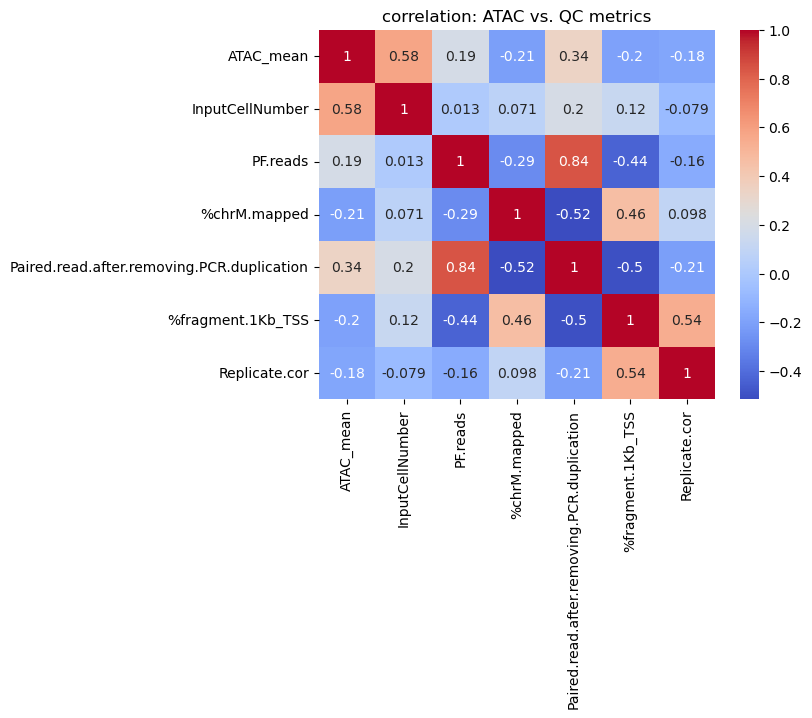

In [65]:
# correlation 
corr = ATAC_combined.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("correlation: ATAC vs. QC metrics")
plt.show()


ATAC signal is not depended on Replicate.cor, %fragment.1Kb_TSS, PF.read and %chrM.mapped. It is weakly depended on Paired.read.after.removing.PCR.duplication and strongly depended on InputCellNumbers